## Mutual information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

## Read Data

In [2]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

In [3]:
data.head()

,Duration,Source,Destination_bytes,Count,Same_srv_rate,Serror_rate,Srv_serror_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_port_rate,...,Service_code,Flag_code,IDS_detection_code,Malware_detection_code,Ashula_detection_code,Source_IP_Address_code,Destination_IP_Address_code,Start_Time_code,Protocol_code,Label_code
0,2.863309,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,90847.0,14024.0,25836.0,1.0,0.0
1,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,218531.0,8968.0,45541.0,1.0,0.0
2,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,176665.0,15997.0,59860.0,1.0,0.0
3,0.000000,0,0,0,0.0,0.0,0.67,49,100,0.02,...,6.0,6.0,0.0,0.0,0.0,52769.0,473.0,40649.0,1.0,0.0
4,0.000000,0,0,1,1.0,0.0,0.36,0,2,0.00,...,6.0,0.0,0.0,0.0,0.0,65048.0,16609.0,39283.0,1.0,0.0


### Train - Test Split

In [4]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code'], axis=1),
    data['Label_code'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 23), (24811, 23))

### Determine Mutual Information

In [5]:
mi = mutual_info_classif(X_test, y_test) 
mi

array([0.0641478 , 0.08350475, 0.1074978 , 0.03155697, 0.02852195,
       0.01409175, 0.03251692, 0.07743243, 0.04235024, 0.00247488,
       0.06860274, 0.04771333, 0.05037172, 0.06728962, 0.06418041,
       0.05465431, 0.00398392, 0.        , 0.        , 0.25914635,
       0.14707674, 0.01408745, 0.04541176])

Text(0, 0.5, 'Mutual Information')

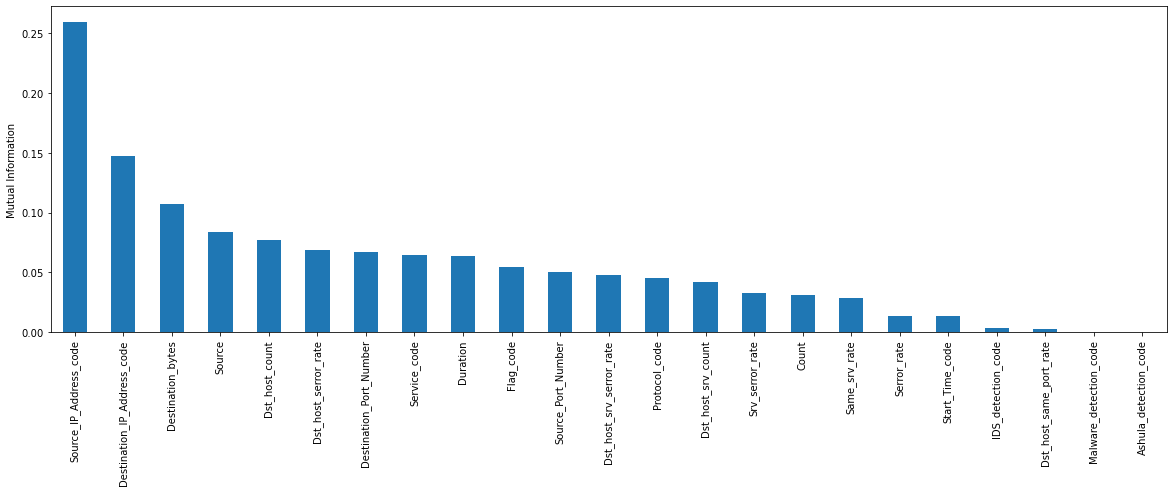

In [6]:
# 1. Let's capture the above array in a pandas series
# 2. Add the variable names in the index
# 3. Sort the features based on their mutual information value
# 4. And make a var plot

mi = pd.Series(mi)
mi.index = X_test.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

### Select top k features based on MI

In [7]:
# select the top 15 features based on their mutual information value
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_test, y_test)

# display features
X_test.columns[sel_.get_support()]

Index(['Duration', 'Source', 'Destination_bytes', 'Count', 'Dst_host_count',
       'Dst_host_srv_count', 'Dst_host_serror_rate',
       'Dst_host_srv_serror_rate', 'Source_Port_Number',
       'Destination_Port_Number', 'Service_code', 'Flag_code',
       'Source_IP_Address_code', 'Destination_IP_Address_code',
       'Protocol_code'],
      dtype='object')

In [8]:
# to remove the rest of the features:

X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

In [9]:
X_train.shape, X_test.shape

((99244, 15), (24811, 15))

## Standardize Data


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers

In [11]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression

In [14]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1).fit(X_train, y_train)

CPU times: user 16.6 ms, sys: 9.54 ms, total: 26.1 ms
Wall time: 1.24 s


In [15]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.3769295876828826
F1 Score: 0.22390682263165818
FPR: 0.683128670581954
TPR: 0.9550321199143469


### Naive Bayes

In [16]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-05).fit(X_train, y_train)

CPU times: user 26.3 ms, sys: 2.38 ms, total: 28.7 ms
Wall time: 26.8 ms


In [17]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.0
FPR: 1.0
TPR: 1.0


### Random Forest


In [18]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 4.8 s, sys: 45.8 ms, total: 4.85 s
Wall time: 4.84 s


In [19]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


### KNN

In [20]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform').fit(X_train, y_train)

CPU times: user 9.9 ms, sys: 1.75 ms, total: 11.6 ms
Wall time: 9.35 ms


In [21]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.9058885171899561
f1: 0.0
fpr: 1.0
tpr: 1.0


### CatBoost

In [21]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6566522	total: 61.6ms	remaining: 3.02s
1:	learn: 0.6228628	total: 70.1ms	remaining: 1.68s
2:	learn: 0.5922300	total: 78ms	remaining: 1.22s
3:	learn: 0.5631556	total: 88.2ms	remaining: 1.01s
4:	learn: 0.5361865	total: 96.1ms	remaining: 865ms
5:	learn: 0.5110438	total: 104ms	remaining: 766ms
6:	learn: 0.4884135	total: 113ms	remaining: 697ms
7:	learn: 0.4666639	total: 121ms	remaining: 638ms
8:	learn: 0.4457293	total: 130ms	remaining: 592ms
9:	learn: 0.4257964	total: 140ms	remaining: 559ms
10:	learn: 0.4082545	total: 148ms	remaining: 525ms
11:	learn: 0.3908261	total: 156ms	remaining: 494ms
12:	learn: 0.3742472	total: 165ms	remaining: 468ms
13:	learn: 0.3589114	total: 173ms	remaining: 445ms
14:	learn: 0.3448578	total: 181ms	remaining: 423ms
15:	learn: 0.3309557	total: 189ms	remaining: 402ms
16:	learn: 0.3177523	total: 197ms	remaining: 383ms
17:	learn: 0.3048183	total: 205ms	remaining: 364ms
18:	learn: 0.2932304	total: 213ms	remaining: 347ms
19:	learn: 0.2819444	total: 220ms	rema

In [22]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
FPR: 1.0
TPR: 1.0


## Model Evaluation


In [22]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../Kyoto_Test.csv")
test_df.shape

(62028, 24)

In [23]:
# Create feature matrix X and target vextor y
y_eval = test_df['Label_code']
X_eval = test_df.drop(columns=['Label_code'])

In [24]:
X_eval = sel_.transform(X_eval)

In [25]:
X_eval.shape

(62028, 15)

### Model Evaluation - Logistic Regression



In [26]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=42)

In [27]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [28]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.9310890330901617
Testing accuracy is  0.3769295876828826


In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.3769295876828826
F1 Score: 0.22390682263165818
Precision Score: 0.12681983621474066
Recall Score: 0.9550321199143469
Confusion Matrix:
 [[ 7122 15354]
 [  105  2230]]


### Cross validation - Logistic Regression




In [30]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.89827 (+/- 0.00304)
F1 Score: 0.00000 (+/- 0.00000)
Precision: 0.00000 (+/- 0.00000)
Recall: 0.00000 (+/- 0.00000)


### Model Evaluation - Naive Bayes





In [31]:
modelNB = GaussianNB(var_smoothing=1e-05)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [32]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [33]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.6197855789770667
Testing accuracy is  0.9058885171899561


In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - Naive Bayes



In [35]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.51849 (+/- 0.28071)
F1 Score: 0.26047 (+/- 0.03042)
Precision: 0.21449 (+/- 0.39171)
Recall: 0.86356 (+/- 0.46002)


### Model Evaluation - Random Forest



In [36]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [37]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [38]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.9058885171899561


In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - Random Forest



In [40]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99956 (+/- 0.00054)
F1 Score: 0.99774 (+/- 0.00281)
Precision: 0.99899 (+/- 0.00223)
Recall: 0.99649 (+/- 0.00380)


### Model Evaluation - KNN

In [41]:
modelKNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=2)

In [42]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [43]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9969267663536334
Testing accuracy is  0.9058885171899561


In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - KNN



In [45]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.98862 (+/- 0.00246)
F1 Score: 0.93916 (+/- 0.01335)
Precision: 0.96960 (+/- 0.01296)
Recall: 0.91061 (+/- 0.01789)


### Model Evaluation - CatBoost

In [46]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6554441	total: 63.6ms	remaining: 3.12s
1:	learn: 0.6207715	total: 70.7ms	remaining: 1.7s
2:	learn: 0.5885230	total: 78.3ms	remaining: 1.23s
3:	learn: 0.5576296	total: 85.8ms	remaining: 986ms
4:	learn: 0.5308487	total: 92.7ms	remaining: 834ms
5:	learn: 0.5044304	total: 99.8ms	remaining: 732ms
6:	learn: 0.4807849	total: 107ms	remaining: 657ms
7:	learn: 0.4579256	total: 114ms	remaining: 599ms
8:	learn: 0.4360803	total: 121ms	remaining: 553ms
9:	learn: 0.4159523	total: 128ms	remaining: 513ms
10:	learn: 0.3970964	total: 135ms	remaining: 480ms
11:	learn: 0.3790521	total: 143ms	remaining: 452ms
12:	learn: 0.3622261	total: 150ms	remaining: 426ms
13:	learn: 0.3462112	total: 158ms	remaining: 405ms
14:	learn: 0.3307757	total: 165ms	remaining: 386ms
15:	learn: 0.3166064	total: 173ms	remaining: 368ms
16:	learn: 0.3030904	total: 180ms	remaining: 350ms
17:	learn: 0.2908936	total: 188ms	remaining: 334ms
18:	learn: 0.2793103	total: 195ms	remaining: 319ms
19:	learn: 0.2677935	total: 202ms	re

In [47]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [48]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9967453951876184
Testing accuracy is  0.9058885171899561


In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - CatBoost

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6559140	total: 6ms	remaining: 294ms
1:	learn: 0.6223754	total: 12.1ms	remaining: 292ms
2:	learn: 0.5912959	total: 17.8ms	remaining: 279ms
3:	learn: 0.5604506	total: 23.4ms	remaining: 269ms
4:	learn: 0.5336694	total: 28.9ms	remaining: 260ms
5:	learn: 0.5076931	total: 34.5ms	remaining: 253ms
6:	learn: 0.4839390	total: 40ms	remaining: 246ms
7:	learn: 0.4609108	total: 46ms	remaining: 241ms
8:	learn: 0.4400346	total: 51.8ms	remaining: 236ms
9:	learn: 0.4200021	total: 57.3ms	remaining: 229ms
10:	learn: 0.4012269	total: 62.9ms	remaining: 223ms
11:	learn: 0.3826796	total: 68.7ms	remaining: 218ms
12:	learn: 0.3664589	total: 74.8ms	remaining: 213ms
13:	learn: 0.3499656	total: 80.5ms	remaining: 207ms
14:	learn: 0.3345030	total: 86.1ms	remaining: 201ms
15:	learn: 0.3203020	total: 92.1ms	remaining: 196ms
16:	learn: 0.3062391	total: 97.6ms	remaining: 189ms
17:	learn: 0.2941152	total: 104ms	remaining: 184ms
18:	learn: 0.2818819	total: 109ms	remaining: 179ms
19:	learn: 0.2700556	total: 115

35:	learn: 0.1425329	total: 205ms	remaining: 79.6ms
36:	learn: 0.1371722	total: 211ms	remaining: 74ms
37:	learn: 0.1315990	total: 216ms	remaining: 68.3ms
38:	learn: 0.1262326	total: 222ms	remaining: 62.7ms
39:	learn: 0.1218773	total: 228ms	remaining: 57ms
40:	learn: 0.1168762	total: 234ms	remaining: 51.3ms
41:	learn: 0.1127436	total: 240ms	remaining: 45.6ms
42:	learn: 0.1090563	total: 245ms	remaining: 39.9ms
43:	learn: 0.1048783	total: 251ms	remaining: 34.2ms
44:	learn: 0.1007666	total: 257ms	remaining: 28.5ms
45:	learn: 0.0974994	total: 262ms	remaining: 22.8ms
46:	learn: 0.0934673	total: 268ms	remaining: 17.1ms
47:	learn: 0.0898026	total: 274ms	remaining: 11.4ms
48:	learn: 0.0861284	total: 279ms	remaining: 5.7ms
49:	learn: 0.0834639	total: 285ms	remaining: 0us
0:	learn: 0.6557525	total: 6.11ms	remaining: 299ms
1:	learn: 0.6222782	total: 11.9ms	remaining: 285ms
2:	learn: 0.5895197	total: 17.6ms	remaining: 275ms
3:	learn: 0.5602075	total: 23.6ms	remaining: 272ms
4:	learn: 0.5324749	tota

0:	learn: 0.6559288	total: 5.89ms	remaining: 289ms
1:	learn: 0.6223904	total: 11.8ms	remaining: 284ms
2:	learn: 0.5914100	total: 17.7ms	remaining: 277ms
3:	learn: 0.5613452	total: 23.8ms	remaining: 274ms
4:	learn: 0.5343316	total: 29.5ms	remaining: 265ms
5:	learn: 0.5084224	total: 35.1ms	remaining: 257ms
6:	learn: 0.4846830	total: 40.7ms	remaining: 250ms
7:	learn: 0.4616378	total: 46.1ms	remaining: 242ms
8:	learn: 0.4407714	total: 51.9ms	remaining: 236ms
9:	learn: 0.4206214	total: 57.3ms	remaining: 229ms
10:	learn: 0.4018672	total: 63.1ms	remaining: 224ms
11:	learn: 0.3833148	total: 68.7ms	remaining: 217ms
12:	learn: 0.3663483	total: 74.2ms	remaining: 211ms
13:	learn: 0.3502380	total: 79.8ms	remaining: 205ms
14:	learn: 0.3347710	total: 85.5ms	remaining: 200ms
15:	learn: 0.3205862	total: 91.4ms	remaining: 194ms
16:	learn: 0.3068279	total: 97ms	remaining: 188ms
17:	learn: 0.2946428	total: 103ms	remaining: 183ms
18:	learn: 0.2824162	total: 108ms	remaining: 177ms
19:	learn: 0.2710429	total

34:	learn: 0.1496174	total: 201ms	remaining: 86.3ms
35:	learn: 0.1440551	total: 207ms	remaining: 80.5ms
36:	learn: 0.1380724	total: 213ms	remaining: 74.8ms
37:	learn: 0.1324903	total: 218ms	remaining: 69ms
38:	learn: 0.1272610	total: 224ms	remaining: 63.2ms
39:	learn: 0.1228866	total: 230ms	remaining: 57.5ms
40:	learn: 0.1177508	total: 236ms	remaining: 51.8ms
41:	learn: 0.1132314	total: 242ms	remaining: 46ms
42:	learn: 0.1095896	total: 247ms	remaining: 40.2ms
43:	learn: 0.1050106	total: 252ms	remaining: 34.4ms
44:	learn: 0.1011815	total: 258ms	remaining: 28.7ms
45:	learn: 0.0979023	total: 264ms	remaining: 22.9ms
46:	learn: 0.0939058	total: 269ms	remaining: 17.2ms
47:	learn: 0.0905903	total: 275ms	remaining: 11.5ms
48:	learn: 0.0868763	total: 281ms	remaining: 5.73ms
49:	learn: 0.0840870	total: 287ms	remaining: 0us
0:	learn: 0.6557049	total: 6.02ms	remaining: 295ms
1:	learn: 0.6222749	total: 11.9ms	remaining: 284ms
2:	learn: 0.5899017	total: 17.6ms	remaining: 276ms
3:	learn: 0.5606392	to

0:	learn: 0.6557525	total: 5.61ms	remaining: 275ms
1:	learn: 0.6222782	total: 11.8ms	remaining: 282ms
2:	learn: 0.5895197	total: 17.6ms	remaining: 275ms
3:	learn: 0.5602075	total: 23.4ms	remaining: 269ms
4:	learn: 0.5324749	total: 29.4ms	remaining: 264ms
5:	learn: 0.5058912	total: 35.4ms	remaining: 259ms
6:	learn: 0.4823413	total: 41ms	remaining: 252ms
7:	learn: 0.4600608	total: 46.9ms	remaining: 246ms
8:	learn: 0.4381316	total: 52.4ms	remaining: 239ms
9:	learn: 0.4179185	total: 58.2ms	remaining: 233ms
10:	learn: 0.3990173	total: 63.9ms	remaining: 226ms
11:	learn: 0.3811518	total: 69.3ms	remaining: 219ms
12:	learn: 0.3642860	total: 74.7ms	remaining: 213ms
13:	learn: 0.3483463	total: 80.2ms	remaining: 206ms
14:	learn: 0.3329973	total: 85.8ms	remaining: 200ms
15:	learn: 0.3188893	total: 91.6ms	remaining: 195ms
16:	learn: 0.3052857	total: 97.2ms	remaining: 189ms
17:	learn: 0.2930685	total: 103ms	remaining: 183ms
18:	learn: 0.2810848	total: 109ms	remaining: 178ms
19:	learn: 0.2696104	total

34:	learn: 0.1485034	total: 201ms	remaining: 86.1ms
35:	learn: 0.1429889	total: 206ms	remaining: 80.2ms
36:	learn: 0.1377981	total: 212ms	remaining: 74.5ms
37:	learn: 0.1320474	total: 218ms	remaining: 68.7ms
38:	learn: 0.1267021	total: 224ms	remaining: 63.1ms
39:	learn: 0.1224560	total: 229ms	remaining: 57.4ms
40:	learn: 0.1175859	total: 235ms	remaining: 51.7ms
41:	learn: 0.1133425	total: 241ms	remaining: 45.9ms
42:	learn: 0.1096092	total: 247ms	remaining: 40.2ms
43:	learn: 0.1051549	total: 253ms	remaining: 34.5ms
44:	learn: 0.1009355	total: 258ms	remaining: 28.7ms
45:	learn: 0.0976798	total: 264ms	remaining: 23ms
46:	learn: 0.0936370	total: 270ms	remaining: 17.2ms
47:	learn: 0.0898903	total: 275ms	remaining: 11.5ms
48:	learn: 0.0862103	total: 281ms	remaining: 5.73ms
49:	learn: 0.0834585	total: 287ms	remaining: 0us
0:	learn: 0.6556925	total: 5.51ms	remaining: 270ms
1:	learn: 0.6222131	total: 11.7ms	remaining: 280ms
2:	learn: 0.5897920	total: 17.4ms	remaining: 273ms
3:	learn: 0.5604798	

0:	learn: 0.6557049	total: 12.4ms	remaining: 607ms
1:	learn: 0.6222749	total: 18.5ms	remaining: 445ms
2:	learn: 0.5899017	total: 24.1ms	remaining: 378ms
3:	learn: 0.5606392	total: 30.2ms	remaining: 347ms
4:	learn: 0.5328682	total: 35.9ms	remaining: 324ms
5:	learn: 0.5064064	total: 41.8ms	remaining: 306ms
6:	learn: 0.4828489	total: 47.6ms	remaining: 293ms
7:	learn: 0.4606225	total: 53.3ms	remaining: 280ms
8:	learn: 0.4386968	total: 58.9ms	remaining: 268ms
9:	learn: 0.4184703	total: 64.6ms	remaining: 258ms
10:	learn: 0.3998445	total: 70.6ms	remaining: 250ms
11:	learn: 0.3811004	total: 76.6ms	remaining: 243ms
12:	learn: 0.3642476	total: 82.4ms	remaining: 235ms
13:	learn: 0.3482536	total: 88.1ms	remaining: 227ms
14:	learn: 0.3329396	total: 94.2ms	remaining: 220ms
15:	learn: 0.3188753	total: 99.9ms	remaining: 212ms
16:	learn: 0.3051101	total: 106ms	remaining: 205ms
17:	learn: 0.2929330	total: 111ms	remaining: 198ms
18:	learn: 0.2814069	total: 117ms	remaining: 191ms
19:	learn: 0.2700465	tota

34:	learn: 0.1466482	total: 204ms	remaining: 87.6ms
35:	learn: 0.1404365	total: 210ms	remaining: 81.8ms
36:	learn: 0.1346819	total: 216ms	remaining: 75.9ms
37:	learn: 0.1292959	total: 222ms	remaining: 70.1ms
38:	learn: 0.1249752	total: 228ms	remaining: 64.3ms
39:	learn: 0.1206790	total: 234ms	remaining: 58.4ms
40:	learn: 0.1158983	total: 239ms	remaining: 52.6ms
41:	learn: 0.1117182	total: 245ms	remaining: 46.7ms
42:	learn: 0.1080356	total: 251ms	remaining: 40.9ms
43:	learn: 0.1037935	total: 257ms	remaining: 35.1ms
44:	learn: 0.1001123	total: 264ms	remaining: 29.3ms
45:	learn: 0.0968210	total: 270ms	remaining: 23.5ms
46:	learn: 0.0928261	total: 276ms	remaining: 17.6ms
47:	learn: 0.0890272	total: 282ms	remaining: 11.7ms
48:	learn: 0.0862435	total: 287ms	remaining: 5.86ms
49:	learn: 0.0835420	total: 293ms	remaining: 0us
0:	learn: 0.6558730	total: 5.82ms	remaining: 285ms
1:	learn: 0.6223821	total: 11.5ms	remaining: 277ms
2:	learn: 0.5913388	total: 17.5ms	remaining: 274ms
3:	learn: 0.560433

0:	learn: 0.6556925	total: 6.03ms	remaining: 295ms
1:	learn: 0.6222131	total: 11.9ms	remaining: 286ms
2:	learn: 0.5897920	total: 17.5ms	remaining: 274ms
3:	learn: 0.5604798	total: 23.3ms	remaining: 267ms
4:	learn: 0.5327009	total: 29.2ms	remaining: 263ms
5:	learn: 0.5061948	total: 34.8ms	remaining: 255ms
6:	learn: 0.4826155	total: 40.3ms	remaining: 247ms
7:	learn: 0.4603641	total: 45.9ms	remaining: 241ms
8:	learn: 0.4384567	total: 51.6ms	remaining: 235ms
9:	learn: 0.4182231	total: 57ms	remaining: 228ms
10:	learn: 0.3995734	total: 62.5ms	remaining: 222ms
11:	learn: 0.3808446	total: 68ms	remaining: 215ms
12:	learn: 0.3639829	total: 73.7ms	remaining: 210ms
13:	learn: 0.3480475	total: 79.4ms	remaining: 204ms
14:	learn: 0.3326994	total: 85.4ms	remaining: 199ms
15:	learn: 0.3186012	total: 91ms	remaining: 193ms
16:	learn: 0.3048205	total: 96.3ms	remaining: 187ms
17:	learn: 0.2926123	total: 102ms	remaining: 181ms
18:	learn: 0.2810685	total: 108ms	remaining: 176ms
19:	learn: 0.2696843	total: 11

34:	learn: 0.1469985	total: 203ms	remaining: 87ms
35:	learn: 0.1410216	total: 209ms	remaining: 81.2ms
36:	learn: 0.1352906	total: 215ms	remaining: 75.4ms
37:	learn: 0.1299601	total: 220ms	remaining: 69.6ms
38:	learn: 0.1247842	total: 226ms	remaining: 63.8ms
39:	learn: 0.1204910	total: 233ms	remaining: 58.2ms
40:	learn: 0.1156569	total: 239ms	remaining: 52.4ms
41:	learn: 0.1112619	total: 244ms	remaining: 46.5ms
42:	learn: 0.1069080	total: 250ms	remaining: 40.7ms
43:	learn: 0.1030448	total: 256ms	remaining: 34.9ms
44:	learn: 0.0994068	total: 262ms	remaining: 29.1ms
45:	learn: 0.0961247	total: 268ms	remaining: 23.3ms
46:	learn: 0.0921474	total: 275ms	remaining: 17.6ms
47:	learn: 0.0884325	total: 281ms	remaining: 11.7ms
48:	learn: 0.0856553	total: 287ms	remaining: 5.87ms
49:	learn: 0.0829092	total: 293ms	remaining: 0us
0:	learn: 0.6556847	total: 6.84ms	remaining: 335ms
1:	learn: 0.6210177	total: 13.5ms	remaining: 325ms
2:	learn: 0.5883933	total: 20ms	remaining: 314ms
3:	learn: 0.5592106	to

0:	learn: 0.6558730	total: 6.52ms	remaining: 319ms
1:	learn: 0.6223821	total: 12.4ms	remaining: 298ms
2:	learn: 0.5913388	total: 18.1ms	remaining: 284ms
3:	learn: 0.5604338	total: 24.8ms	remaining: 285ms
4:	learn: 0.5336218	total: 31.8ms	remaining: 286ms
5:	learn: 0.5078075	total: 38.8ms	remaining: 284ms
6:	learn: 0.4828398	total: 45.3ms	remaining: 278ms
7:	learn: 0.4598818	total: 51.9ms	remaining: 273ms
8:	learn: 0.4379639	total: 58.5ms	remaining: 266ms
9:	learn: 0.4179178	total: 64.3ms	remaining: 257ms
10:	learn: 0.3992182	total: 69.9ms	remaining: 248ms
11:	learn: 0.3808230	total: 75.7ms	remaining: 240ms
12:	learn: 0.3646715	total: 82.4ms	remaining: 235ms
13:	learn: 0.3484545	total: 88.3ms	remaining: 227ms
14:	learn: 0.3331944	total: 93.9ms	remaining: 219ms
15:	learn: 0.3184803	total: 100ms	remaining: 213ms
16:	learn: 0.3048746	total: 106ms	remaining: 205ms
17:	learn: 0.2927263	total: 111ms	remaining: 198ms
18:	learn: 0.2805419	total: 117ms	remaining: 191ms
19:	learn: 0.2688497	total

32:	learn: 0.1578482	total: 201ms	remaining: 103ms
33:	learn: 0.1519020	total: 206ms	remaining: 97.1ms
34:	learn: 0.1465772	total: 212ms	remaining: 90.9ms
35:	learn: 0.1404687	total: 217ms	remaining: 84.5ms
36:	learn: 0.1347112	total: 223ms	remaining: 78.4ms
37:	learn: 0.1294521	total: 230ms	remaining: 72.5ms
38:	learn: 0.1251268	total: 236ms	remaining: 66.6ms
39:	learn: 0.1208338	total: 243ms	remaining: 60.7ms
40:	learn: 0.1164561	total: 249ms	remaining: 54.8ms
41:	learn: 0.1121022	total: 256ms	remaining: 48.7ms
42:	learn: 0.1075150	total: 263ms	remaining: 42.8ms
43:	learn: 0.1034067	total: 269ms	remaining: 36.7ms
44:	learn: 0.0997482	total: 276ms	remaining: 30.7ms
45:	learn: 0.0964517	total: 283ms	remaining: 24.6ms
46:	learn: 0.0924720	total: 289ms	remaining: 18.4ms
47:	learn: 0.0891835	total: 296ms	remaining: 12.3ms
48:	learn: 0.0863770	total: 302ms	remaining: 6.17ms
49:	learn: 0.0836651	total: 308ms	remaining: 0us
0:	learn: 0.6555602	total: 5.96ms	remaining: 292ms
1:	learn: 0.62206

In [51]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99657 (+/- 0.00170)
F1 Score: 0.98189 (+/- 0.00911)
Precision: 0.99828 (+/- 0.00267)
Recall: 0.96608 (+/- 0.01752)
